In [97]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt

In [73]:
pauli_x = [[0., 1.], [1., 0.]]
pauli_y = [[0., -1.j], [1.j, 0.]]
pauli_z = [[1., 0.], [0., -1.]]

pauli = jnp.asarray([pauli_x, pauli_y, pauli_z])

basis = jnp.asarray([jnp.eye(2), pauli_x, pauli_y, pauli_z])

In [165]:
# Determininstic evolution
omega0 = 5.
hamiltonian_0 = -0.5*omega0*pauli[2]

# Noisy evolution
gamma = 0.1
theta, phi = 0., 0.
n = jnp.asarray([jnp.cos(phi)*jnp.sin(theta), jnp.sin(phi)*jnp.sin(theta), jnp.cos(theta)])
kraus = jnp.sqrt(gamma) * jnp.einsum('a, aij -> aij', n, pauli)

# Control
v_x, v_y, v_z, = 0., 0., 0.
v = jnp.asarray([v_x, v_y, v_z])
hamiltonian_control = jnp.einsum('a, aij -> ij', v, pauli)

def lindbladian(rho, hamiltonian, kraus):
    deterministic = -1.j * (hamiltonian @ rho - rho @ hamiltonian)
    stochastic = jnp.sum(jnp.array(
        [k@(rho @ jnp.conjugate(k.T)) - 0.5*(k.T @ k @ rho + rho @ k.T @ k) for k in kraus]
        ))
    return deterministic + stochastic


In [166]:
def get_coords(matrix, basis):
    return 0.5*jnp.einsum('ij, aji -> a', matrix, basis)

def get_matrix(coords, basis):
    return jnp.einsum('a, aij -> ij', coords, basis)

In [178]:
s = jnp.asarray([1., 0., 0.])
state = 0.5*(jnp.eye(2) + jnp.einsum('a, aij -> ij', s, pauli))

dt = 0.05
time = np.arange(0, 2*jnp.pi, dt)
fidelity = []

for idx in range(len(time)):
    rho_coords = get_coords(state, basis)

    control_ = jnp.array([5, 0. , 0.])
    control_ = jnp.einsum('a, aij -> ij', control_, pauli)
    
    lindbladian_matrix = []
    for nu in basis:
        lindbladian_matrix.append(0.5*jnp.einsum('ij, aji -> a', lindbladian(nu, hamiltonian_0 + control_, kraus), basis))
    lindbladian_matrix = jnp.asarray(lindbladian_matrix).T

    rho_evolved_coords = jax.scipy.linalg.expm(lindbladian_matrix * dt) @ rho_coords
    state = get_matrix(rho_evolved_coords, basis)

    fidelity.append(jnp.trace(state @ state))

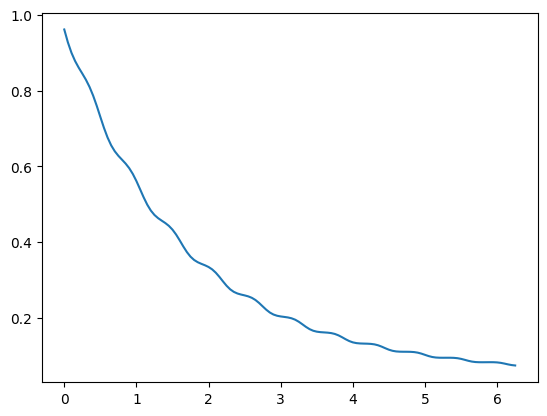

In [179]:
plt.plot(time, fidelity)
plt.show()

In [169]:
state

Array([[ 0.5006276+0.j        , -0.2658675-0.00784276j],
       [-0.2658675+0.00784276j,  0.5006276+0.j        ]], dtype=complex64)